# CS 452/552 Data Science with Python: Homework 4

Download data files from LMS. Code/Explain your solution over this `IPython` notebook at required cells, and complete locally.

To submit your assignment, in LMS, upload your solution to LMS as a single notebook with following file name format:

`lastName_firstName_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 452 or CS 552).

Problems on homework assignments are equally weighted.

Any type of plagiarism will not be tolerated. Your submitted codes will be compared with other submissions and also the codes available on internet and violations will have a penalty of -100 points. (In case of copying from
another student both parties will get -100)

Import libraries

In [9]:
#Import libraries before starting
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.

### Part 1(a): Detecting vegetation in satellite images

The following files contain sampled locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetation and 0 indicating otherwise. 

### Step 1: Load the data and explore

Let's load the four datasets and visualize the data. That is, let's plot the data points by longitude and latitude. Let's also color code the points: green if the location is vegetation and white otherwise.

**Solution:**

In [5]:
def load_dataset(file_path):
    return np.loadtxt(file_path, delimiter=',')

In [6]:
datasets = [load_dataset(f'datasets/dataset_{i}.txt') for i in range(1, 5)]

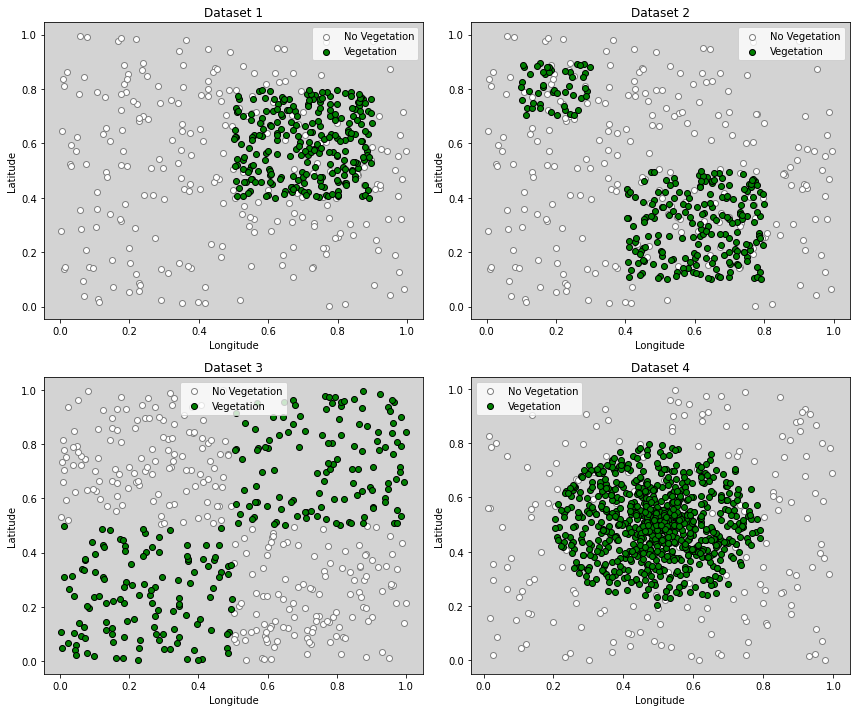

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, data in enumerate(datasets):
    latitudes = data[:, 0]
    longitudes = data[:, 1]
    labels = data[:, 2]

    vegetation = data[labels == 1]
    non_vegetation = data[labels == 0]

    axs[i].scatter(non_vegetation[:, 1], non_vegetation[:, 0], c='white', edgecolors='gray', label='No Vegetation')
    axs[i].scatter(vegetation[:, 1], vegetation[:, 0], c='green', edgecolors='black', label='Vegetation')

    axs[i].set_title(f'Dataset {i+1}')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].legend()
    axs[i].set_facecolor('lightgray')

plt.tight_layout()
plt.show()

**Explanation:**

All the dataset's have different patterns in terms of linearity and complexity to separate vegetation class from no vegetation one. In this case, performances of different datasets can change with the same model or we cannot represent patterns in some dataset with the other dataset's classifier.

### Step 2: Classify locations with vegetation

How can we use the models we have studied so far to identify the boundaries of the vegetation regions? 

Let's consider:

    1. linear or polynomial logistic regression
    2. decision trees

Logistic Regression (Linear & Polynomial)
* A straight line, sometimes known as a hyperplane, is identified via linear logistic regression as the boundary between areas with and without vegetation.
* In order to identify curved boundaries, polynomial logistic regression converts input features into higher-degree combinations.
* Decision boundary found by evaluating the sigmoid output and drawing where probability ≈ 0.5.

Decision Tree
* In order to learn axis-aligned rectangles, a decision tree divides the space along feature axes (latitude and longitude).
* Until a stopping condition (such as depth) is satisfied, it divides the feature space recursively.
* The contour of these divisions that set classes apart is called the boundary.

#### Question 1:
Looking at the data, can you intuitively tell which model will perform best on which data set?


#### Question 2:
What do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case?

Question 1
* Dataset 1 looks separable with higher degree line — a polynomial logistic regression would perform enough.
* Dataset 3 and Dataset 4 appear more complex and separated by different blocks — decision trees would likely perform better due to their ability to model irregular boundaries.
* Dataset 4 have elliptical separation — a polynomial logistic regression is more suitable.

Question 2
* Depth controls how complex the tree is
* A shallow tree (depth 1-2) is suitable for broad patterns because it can only split a few times.
* Although it runs the danger of overfitting, a deeper tree (depth 5+) can suit more complex regions.

* Dataset 1: Depth 1–2 should suffice since the decision boundary appears simple and nearly linear.
* Dataset 2: A depth of 4–6 would likely be needed to fit the more fragmented vegetation regions.
* Dataset 3: A depth of 2–3 might be enough to capture the mild non-linearity.
* Dataset 4: A tree with a depth of 5–7 is more suitable since the vegetation pattern appears to be the most intricate due to elliptical pattern.

**Solution:**

In [11]:
data = datasets[0]
X = data[:, :2]
y = data[:, 2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, y_train.shape

((400, 2), (400,))

In [13]:
X_test.shape, y_test.shape

((100, 2), (100,))

In [10]:
def plot_decision_boundary(model, X, y, ax, title):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap='Greens')
    ax.scatter(X[y==0][:, 0], X[y==0][:, 1], color='white', edgecolor='gray', label='No Veg')
    ax.scatter(X[y==1][:, 0], X[y==1][:, 1], color='green', edgecolor='black', label='Veg')
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.legend()
    ax.set_facecolor('lightgray')

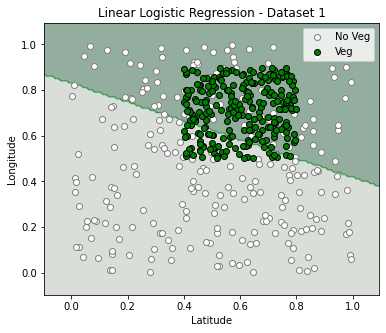

In [14]:
linear_model = LogisticRegression()
linear_model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 5))
plot_decision_boundary(linear_model, X, y, ax, "Linear Logistic Regression - Dataset 1")
plt.show()

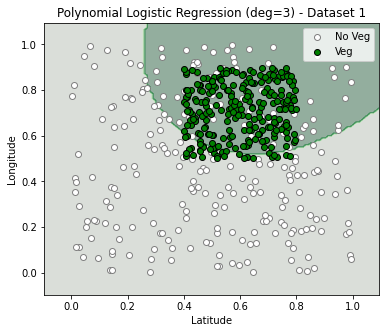

In [15]:
poly_model = make_pipeline(PolynomialFeatures(degree=3), LogisticRegression())
poly_model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 5))
plot_decision_boundary(poly_model, X, y, ax, "Polynomial Logistic Regression (deg=3) - Dataset 1")
plt.show()

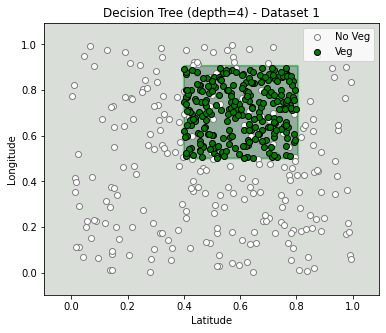

In [16]:
tree_model = DecisionTreeClassifier(max_depth=4, random_state=0)
tree_model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 5))
plot_decision_boundary(tree_model, X, y, ax, "Decision Tree (depth=4) - Dataset 1")
plt.show()

**Explanation:**

For dataset 1, from the decision boundaries of different models which are linear logistic regression, polynomial logistic regression and decision tree we can see that decision tree separates better in terms of separation of the classes purely. Other models cannot separate the boundaries of different classes smoothly instead there are regions that have data points from two classes which is sign of bad separation.

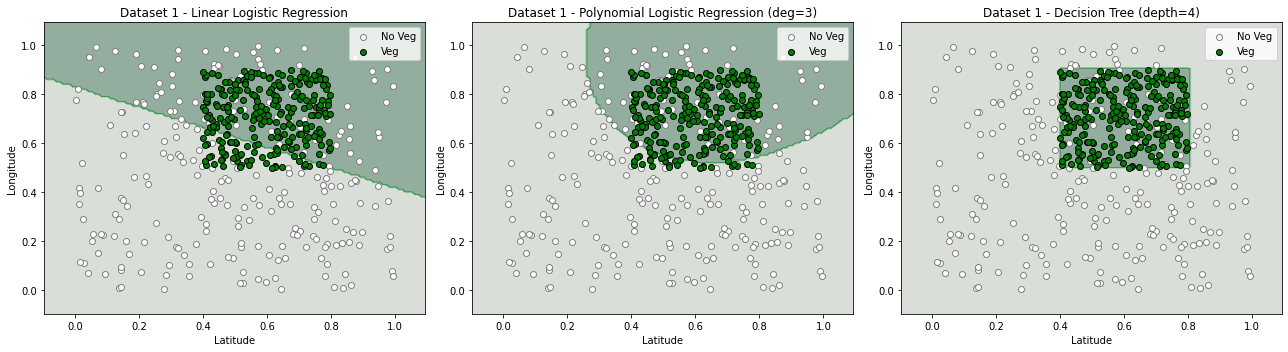

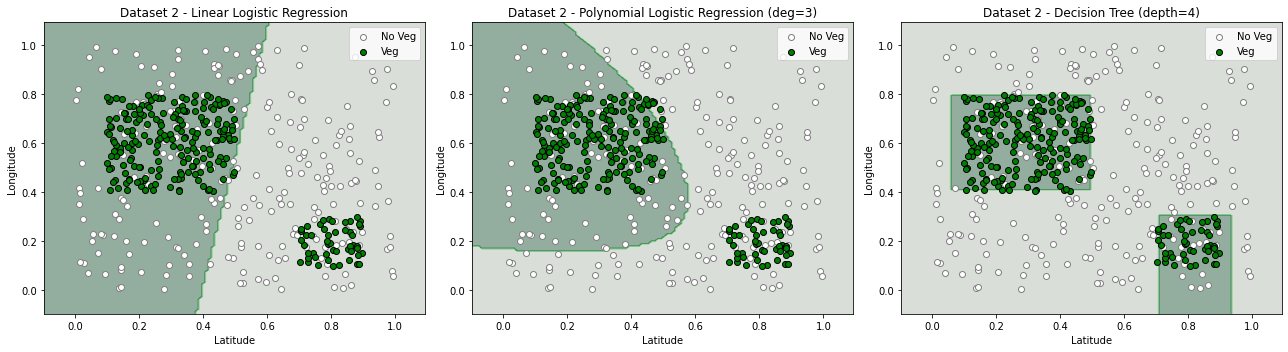

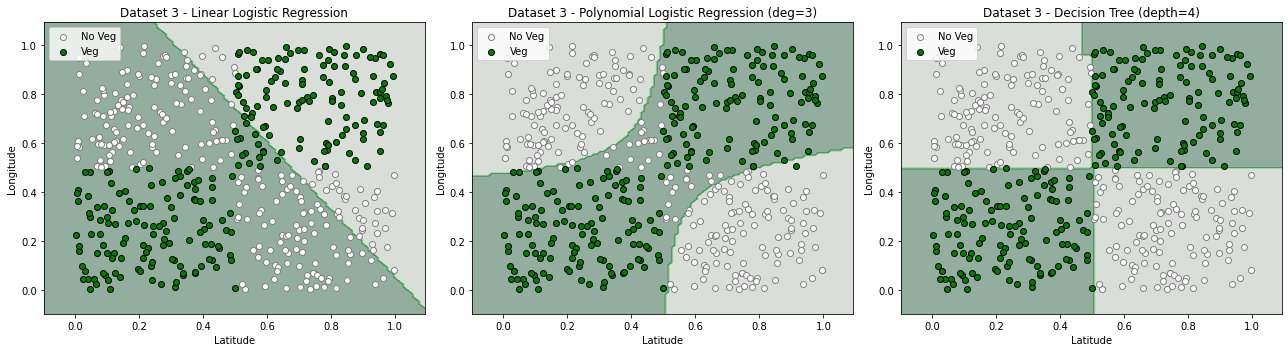

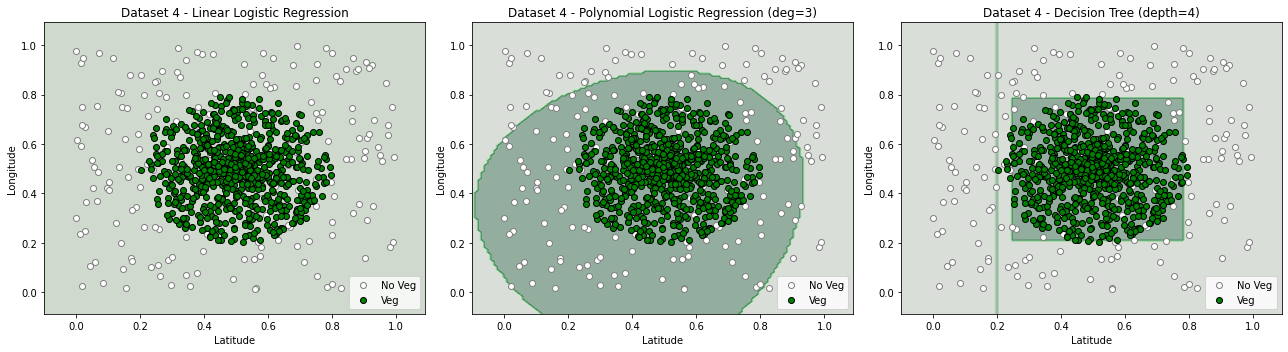

In [17]:
data_1 = datasets[0]
data_2 = datasets[1]
data_3 = datasets[2]
data_4 = datasets[3]

all_data = [data_1, data_2, data_3, data_4]
dataset_names = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]

for i, data in enumerate(all_data):
    X = data[:, :2]
    y = data[:, 2]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    linear_model = LogisticRegression()
    poly_model = make_pipeline(PolynomialFeatures(degree=3), LogisticRegression())
    tree_model = DecisionTreeClassifier(max_depth=4, random_state=0)

    linear_model.fit(X_train, y_train)
    poly_model.fit(X_train, y_train)
    tree_model.fit(X_train, y_train)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    plot_decision_boundary(linear_model, X, y, axs[0], f"{dataset_names[i]} - Linear Logistic Regression")
    plot_decision_boundary(poly_model, X, y, axs[1], f"{dataset_names[i]} - Polynomial Logistic Regression (deg=3)")
    plot_decision_boundary(tree_model, X, y, axs[2], f"{dataset_names[i]} - Decision Tree (depth=4)")

    plt.tight_layout()
    plt.show()

### Part 1(b). What is the best splitting criterion for decision trees?
Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. [Part 1 = (Class 1: 11, Class 0: 37), Part 2 = (Class 1: 40, Class 0: 12)]
2. [Part 1 = (Class 1: 25, Class 0: 48), Part 2 (Class 1: 26, Class 0: 1)]

Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

**Explanation:**

In [18]:
def classification_error(p1):
    return 1 - max(p1, 1 - p1)

In [19]:
def gini(p1):
    return 1 - p1**2 - (1 - p1)**2

In [20]:
def entropy(p1):
    if p1 in [0, 1]:  
        return 0
    return -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)

In [21]:
# Split 1
part1_1 = (11, 37)
part2_1 = (40, 12)

# Split 2
part1_2 = (25, 48)
part2_2 = (26, 1)

In [22]:
def weighted_criterion(split, criterion_fn):
    total = sum(sum(part) for part in split)
    weighted = 0
    for part in split:
        p1 = part[0] / sum(part)
        weighted += criterion_fn(p1) * (sum(part) / total)
    return weighted

In [23]:
criteria = {
    "Classification Error": classification_error,
    "Gini": gini,
    "Entropy": entropy
}

results = {}

for name, fn in criteria.items():
    val1 = weighted_criterion([part1_1, part2_1], fn)
    val2 = weighted_criterion([part1_2, part2_2], fn)
    results[name] = (val1, val2)

for name, (val1, val2) in results.items():
    better = "Split 1" if val1 < val2 else "Split 2"
    print(f"{name}:")
    print(f"  Split 1 = {val1:.4f}")
    print(f"  Split 2 = {val2:.4f}")
    print(f"  Better: {better}\n")

Classification Error:
  Split 1 = 0.2300
  Split 2 = 0.2600
  Better: Split 1

Gini:
  Split 1 = 0.3542
  Split 2 = 0.3480
  Better: Split 2

Entropy:
  Split 1 = 0.7780
  Split 2 = 0.7385
  Better: Split 2



* The simplest statistic is Classification Error, which merely takes into account each node's most frequent class. This metric indicates that Split 1 is better since it incorrectly classifies a lower percentage of points overall.
* Within each split, the Gini Index and Entropy are more prone to class distributions. Even if the majority class stays the same, they penalize "impure" nodes more severely. Split 2 achieves somewhat purer splits on average since its Gini Index is slightly lower. Additionally, Split 2 has a lower entropy, suggesting a larger decrease in disorder or uncertainty.
* Despite Split 1's lower classification error, Split 2 is preferred by the Gini Index and Entropy. In reality:
    * Since Gini and Entropy are more sensitive to node purity and better capture data structure, they are recommended criteria for decision tree creation.
    * Consequently, even though Split 2 has a little larger classification error, it is still thought to be the better option overall for decision tree training.

### Step 3: Evaluate our modeling choices

Recall that when creating our decision tree, we can decide on a split according classification error, Gini coefficient, and Entropy criteria. Which criterion is better, i.e. yield a better model? Or perhaps all three criteria will always produce the same splits?

Let's explore these three criteria using a simple example.

Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. $((11,37), (40,12))$  
2. $((25,48), (26,1))$

**Solution:**

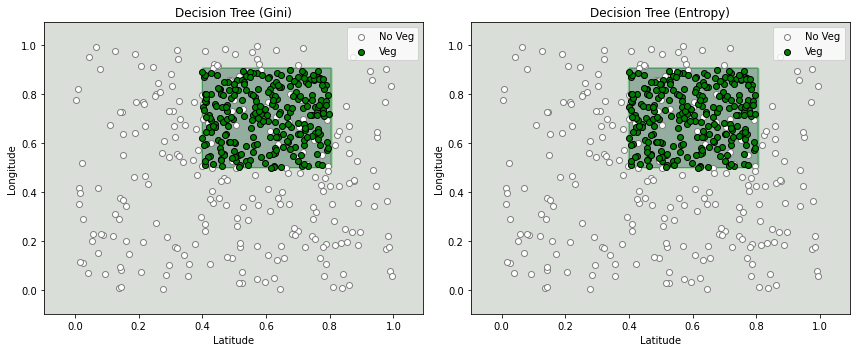

In [25]:
X = data_1[:, :2]
y = data_1[:, 2]

tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=4)
tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4)

tree_gini.fit(X, y)
tree_entropy.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(tree_gini, X, y, axes[0], "Decision Tree (Gini)")
plot_decision_boundary(tree_entropy, X, y, axes[1], "Decision Tree (Entropy)")
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, classification_report

tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=4).fit(X_train, y_train)
tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(X_train, y_train)

y_pred_gini = tree_gini.predict(X_test)
y_pred_entropy = tree_entropy.predict(X_test)

print("Gini Tree Accuracy:", accuracy_score(y_test, y_pred_gini))
print("Entropy Tree Accuracy:", accuracy_score(y_test, y_pred_entropy))

print("\nGini Tree Classification Report:\n", classification_report(y_test, y_pred_gini))
print("\nEntropy Tree Classification Report:\n", classification_report(y_test, y_pred_entropy))

Gini Tree Accuracy: 0.915
Entropy Tree Accuracy: 0.915

Gini Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.73      0.79        44
         1.0       0.93      0.97      0.95       156

    accuracy                           0.92       200
   macro avg       0.90      0.85      0.87       200
weighted avg       0.91      0.92      0.91       200


Entropy Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.73      0.79        44
         1.0       0.93      0.97      0.95       156

    accuracy                           0.92       200
   macro avg       0.90      0.85      0.87       200
weighted avg       0.91      0.92      0.91       200



We can select the best split criteria from Gini Index, Entropy and Classification Error with the comparison of classification resports which are consists of precision, recall, f1-score then choose the criteria with the highest scores

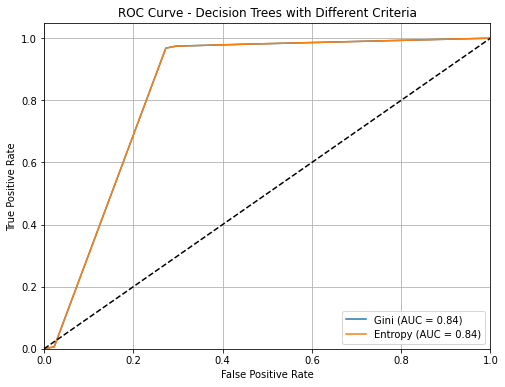

In [27]:
from sklearn.metrics import roc_curve, auc

tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=4)
tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4)

tree_gini.fit(X_train, y_train)
tree_entropy.fit(X_train, y_train)

y_scores_gini = tree_gini.predict_proba(X_test)[:, 1]
y_scores_entropy = tree_entropy.predict_proba(X_test)[:, 1]

fpr_gini, tpr_gini, _ = roc_curve(y_test, y_scores_gini)
roc_auc_gini = auc(fpr_gini, tpr_gini)

fpr_entropy, tpr_entropy, _ = roc_curve(y_test, y_scores_entropy)
roc_auc_entropy = auc(fpr_entropy, tpr_entropy)

plt.figure(figsize=(8,6))
plt.plot(fpr_gini, tpr_gini, label=f'Gini (AUC = {roc_auc_gini:.2f})')
plt.plot(fpr_entropy, tpr_entropy, label=f'Entropy (AUC = {roc_auc_entropy:.2f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Trees with Different Criteria')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Explanation:**

Although the three criteria are intended to assess a split's quality, they don't always yield the same outcome. In this example:
* Split 1 is chosen by the Classification Error.
* Split 2 is preferred by the Gini Index and Entropy.

Since Gini and Entropy are more sensitive to node impurity, they are typically better choices. By penalizing splits that result in mixed classes in child nodes, they improve tree architectures and make models more broadly applicable. In conclusion, Gini and Entropy are usually favored for decision tree training, even though classification error is easier to understand and occasionally matches the other criterion.

## Problem 2: Loan Risk Assessment
In this problem, you are asked by an Unamed National Bank to build a risk assessment model that predicts whether or not it is risky to give a loan to an applicant based on the information provided in their application. Traditionally, loan applications are processed and assessed by hand, but now the bank wants to move to an automated loan processing system. That is, the bank will provide you with loan applications that it has processed in the past for you to build a classifier for risk assessment, going forward, the bank will reject the loan applications from applicants labeled risky and approve the applications that are labeled safe by your model.

The relevant training and test sets are provided in the files: `dataset_5_train.txt` and `dataset_5.test.txt`. The training and testing sets are created from both approved and rejected loan applications that the bank has processed by hand in the past. The first 24 columns contain attributes for each applicant gathered from their application, and the last column contains the credit risk assessment with 1 indicating that the customer is a loan risk, and 0 indicating that the customer is not a loan risk. The names of the attributes are provided in the file `dataset_5_description.txt`.


### Part 2(a): A simple decision tree model
- Fit a simple decision tree of depth 2 to the training set and report its accuracy on the test set. 


### Step 1: Importing Data

**Solution:**

In [91]:
import pandas as pd
import numpy as np

train_file = 'datasets/dataset_5_train.txt'
test_file = 'datasets/dataset_5_test.txt'

In [92]:
column_names = [f'X{i}' for i in range(24)] + ['target']

In [93]:
train_df = pd.read_csv(train_file, header=None, names=column_names)
test_df = pd.read_csv(test_file, header=None, names=column_names)

In [94]:
print("Training Data:")
print(train_df.head())
print(f"Train shape: {train_df.shape}")

print("\nTest Data:")
print(test_df.head())
print(f"Test shape: {test_df.shape}")

Training Data:
       X0        X1   X2   X3   X4    X5   X6   X7   X8   X9  ...      X15  \
0  3652.0  210000.0  2.0  3.0  1.0  28.0  0.0  0.0  0.0  0.0  ...  41084.0   
1  3662.0  110000.0  2.0  3.0  1.0  55.0 -1.0  2.0  0.0  0.0  ...   5819.0   
2  3530.0   70000.0  1.0  3.0  1.0  45.0  2.0  2.0  2.0  2.0  ...  67338.0   
3  3827.0  130000.0  1.0  1.0  1.0  40.0  2.0  2.0  0.0  0.0  ...  86407.0   
4  3288.0  710000.0  2.0  2.0  1.0  40.0 -2.0 -2.0 -2.0 -1.0  ...   1004.0   

       X16      X17     X18     X19     X20     X21      X22     X23  target  
0  42416.0  43707.0  2000.0  2000.0  2000.0  2000.0   2000.0  2000.0     0.0  
1   4807.0   5579.0     0.0  1087.0  1532.0     0.0   1000.0     0.0     1.0  
2  70769.0  68957.0  3100.0  3008.0     0.0  5100.0   2600.0     0.0     1.0  
3  88959.0  97487.0     0.0  5000.0  5000.0  4000.0  10000.0  3724.0     1.0  
4    854.0   8626.0     0.0     0.0  1004.0     0.0   8000.0  5000.0     1.0  

[5 rows x 25 columns]
Train shape: (9750,

**Explanation:**

In [137]:
# For dataset understanding, look for the readed csv file's head (it can be understandable to see both columns and values)

### Step 2: First look at the data

**Solution:**

In [95]:
print("Training Data Summary Statistics:")
print(train_df.describe())

Training Data Summary Statistics:
                X0             X1           X2           X3           X4  \
count  9750.000000    9750.000000  9750.000000  9750.000000  9750.000000   
mean   3399.346051  154596.685128     1.587179     1.866667     1.542051   
std     253.006995  127038.656035     0.492366     0.773090     0.521588   
min    3001.000000   10000.000000     1.000000     0.000000     0.000000   
25%    3288.000000   50000.000000     1.000000     1.000000     1.000000   
50%    3298.000000  120000.000000     2.000000     2.000000     2.000000   
75%    3585.000000  220000.000000     2.000000     2.000000     2.000000   
max    3827.000000  760000.000000     2.000000     6.000000     3.000000   

                X5           X6           X7           X8           X9  ...  \
count  9750.000000  9750.000000  9750.000000  9750.000000  9750.000000  ...   
mean     35.551385     0.228923     0.082872     0.032000    -0.043590  ...   
std       9.427644     1.278969     1.352486

In [96]:
print("\nTraining Data Target Value Counts:")
print(train_df['target'].value_counts())


Training Data Target Value Counts:
target
1.0    4891
0.0    4859
Name: count, dtype: int64


In [97]:
print("\nTest Data Target Value Counts:")
print(test_df['target'].value_counts())


Test Data Target Value Counts:
target
1.0    128
0.0    122
Name: count, dtype: int64


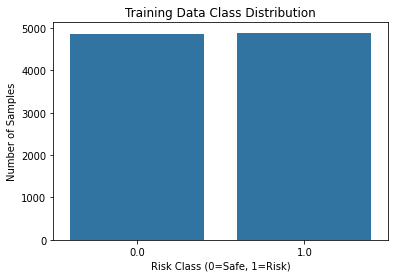

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='target', data=train_df)
plt.title('Training Data Class Distribution')
plt.xlabel('Risk Class (0=Safe, 1=Risk)')
plt.ylabel('Number of Samples')
plt.show()

**Explanation:**

Number of instances in the classes are balanced for the prediction. If the one class dominate other, there can be misleading results while training. Both in training and test sets, we have similar number of instances for safe and risk classes that we can see in 4891 instances for risk and 4859 instances for safe in the training set.

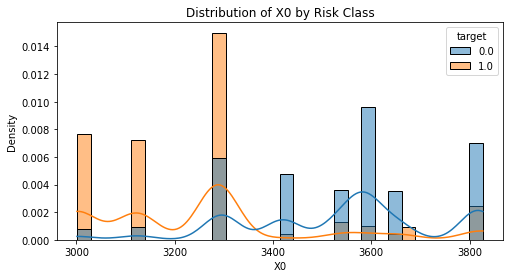

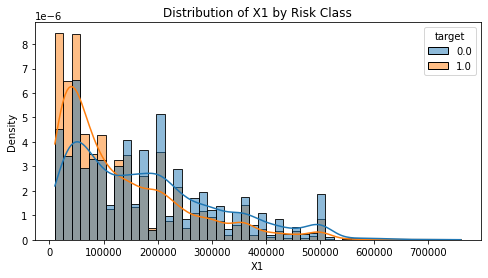

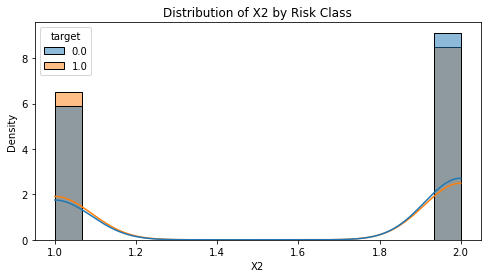

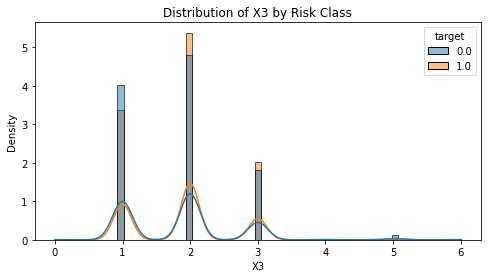

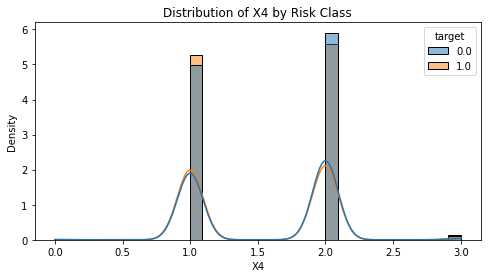

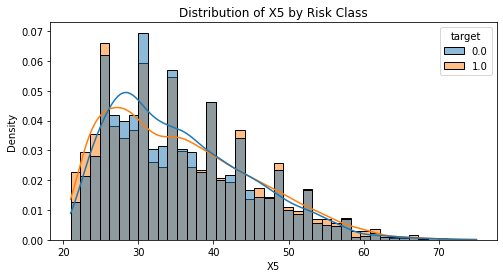

In [43]:
features_to_plot = train_df.columns[:6] 

for feature in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.histplot(data=train_df, x=feature, hue='target', kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {feature} by Risk Class')
    plt.show()

### Step 3: Data cleanup

**Solution:**

In [99]:
print("Missing values in training data:\n", train_df.isnull().sum())

Missing values in training data:
 X0        0
X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
X8        0
X9        0
X10       0
X11       0
X12       0
X13       0
X14       0
X15       0
X16       0
X17       0
X18       0
X19       0
X20       0
X21       0
X22       0
X23       0
target    0
dtype: int64


In [100]:
print("Missing values in test data:\n", test_df.isnull().sum())

Missing values in test data:
 X0        0
X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
X8        0
X9        0
X10       0
X11       0
X12       0
X13       0
X14       0
X15       0
X16       0
X17       0
X18       0
X19       0
X20       0
X21       0
X22       0
X23       0
target    0
dtype: int64


In [46]:
print("\nTraining data types:\n", train_df.dtypes)


Training data types:
 X0        float64
X1        float64
X2        float64
X3        float64
X4        float64
X5        float64
X6        float64
X7        float64
X8        float64
X9        float64
X10       float64
X11       float64
X12       float64
X13       float64
X14       float64
X15       float64
X16       float64
X17       float64
X18       float64
X19       float64
X20       float64
X21       float64
X22       float64
X23       float64
target    float64
dtype: object


In [101]:
print("\nChecking for any suspicious negative values in repayment status columns (X6 - X11):")
print(train_df.loc[:, 'X6':'X11'].describe())


Checking for any suspicious negative values in repayment status columns (X6 - X11):
                X6           X7           X8           X9          X10  \
count  9750.000000  9750.000000  9750.000000  9750.000000  9750.000000   
mean      0.228923     0.082872     0.032000    -0.043590    -0.105949   
std       1.278969     1.352486     1.342627     1.324105     1.288816   
min      -2.000000    -2.000000    -2.000000    -2.000000    -2.000000   
25%      -1.000000    -1.000000    -1.000000    -1.000000    -1.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       8.000000     8.000000     8.000000     8.000000     8.000000   

               X11  
count  9750.000000  
mean     -0.140410  
std       1.295533  
min      -2.000000  
25%      -1.000000  
50%       0.000000  
75%       0.000000  
max       8.000000  


In [48]:
for col in ['X6','X7','X8','X9','X10','X11']:
    mode_val = train_df[col].mode()[0]  # mode of training data
    train_df[col].replace(-2, mode_val, inplace=True)
    test_df[col].replace(-2, mode_val, inplace=True)

print("Counts of -2 values after replacement in training set:")
print((train_df.loc[:, 'X6':'X11'] == -2).sum())

print("\nCounts of -2 values after replacement in test set:")
print((test_df.loc[:, 'X6':'X11'] == -2).sum())

print("\nSummary stats of repayment columns after replacement:")
print(train_df.loc[:, 'X6':'X11'].describe())


Counts of -2 values after replacement in training set:
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
dtype: int64

Counts of -2 values after replacement in test set:
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
dtype: int64

Summary stats of repayment columns after replacement:
                X6           X7           X8           X9          X10  \
count  9750.000000  9750.000000  9750.000000  9750.000000  9750.000000   
mean      0.384821     0.315897     0.287590     0.232513     0.183487   
std       1.108262     1.127025     1.099874     1.071832     1.029404   
min      -1.000000    -1.000000    -1.000000    -1.000000    -1.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       8.000000     8.000000     8.000000     8.000000     8.000000   

               X11  
count  9750.0000

**Explanation:**

The value of -1 in the repayment status columns (X6–X11) denotes "pay duly" (on-time payment), which is a legitimate and significant status and is therefore kept exactly as is. Nevertheless, the value -2 is likely indicative of missing or inaccurate data and does not match to any recorded status. In order to deal with these faulty entries without losing crucial information, substitute the mode (most frequent valid status) for -2.

### Step 4: Prepare data for modelling

**Solution:**

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_df.rename(columns={train_df.columns[-1]: 'label'}, inplace=True)
test_df.rename(columns={test_df.columns[-1]: 'label'}, inplace=True)

X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

In [103]:
print("Original X_train Info:")
print(X_train.info())
print("\nOriginal X_train Description:")
print(X_train.describe())

Original X_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9750 entries, 0 to 9749
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      9750 non-null   float64
 1   X1      9750 non-null   float64
 2   X2      9750 non-null   float64
 3   X3      9750 non-null   float64
 4   X4      9750 non-null   float64
 5   X5      9750 non-null   float64
 6   X6      9750 non-null   float64
 7   X7      9750 non-null   float64
 8   X8      9750 non-null   float64
 9   X9      9750 non-null   float64
 10  X10     9750 non-null   float64
 11  X11     9750 non-null   float64
 12  X12     9750 non-null   float64
 13  X13     9750 non-null   float64
 14  X14     9750 non-null   float64
 15  X15     9750 non-null   float64
 16  X16     9750 non-null   float64
 17  X17     9750 non-null   float64
 18  X18     9750 non-null   float64
 19  X19     9750 non-null   float64
 20  X20     9750 non-null   float64
 21  X21     9750 n

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nScaled X_train Info:")
print(X_train_scaled_df.info())
print("\nScaled X_train Description:")
print(X_train_scaled_df.describe())


Scaled X_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9750 entries, 0 to 9749
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      9750 non-null   float64
 1   X1      9750 non-null   float64
 2   X2      9750 non-null   float64
 3   X3      9750 non-null   float64
 4   X4      9750 non-null   float64
 5   X5      9750 non-null   float64
 6   X6      9750 non-null   float64
 7   X7      9750 non-null   float64
 8   X8      9750 non-null   float64
 9   X9      9750 non-null   float64
 10  X10     9750 non-null   float64
 11  X11     9750 non-null   float64
 12  X12     9750 non-null   float64
 13  X13     9750 non-null   float64
 14  X14     9750 non-null   float64
 15  X15     9750 non-null   float64
 16  X16     9750 non-null   float64
 17  X17     9750 non-null   float64
 18  X18     9750 non-null   float64
 19  X19     9750 non-null   float64
 20  X20     9750 non-null   float64
 21  X21     9750 no

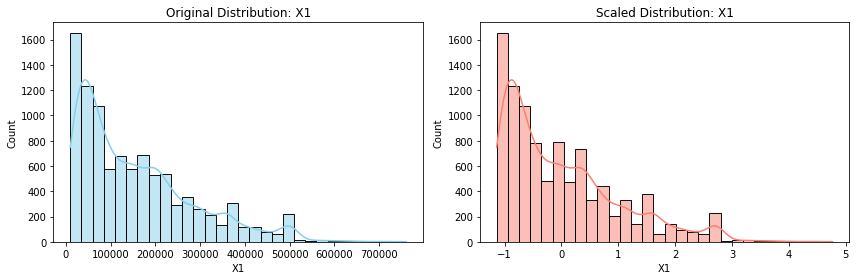

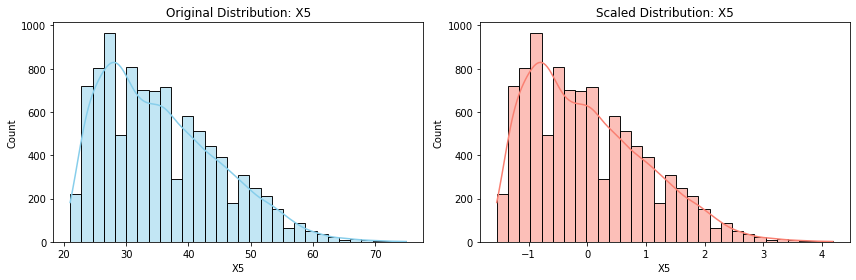

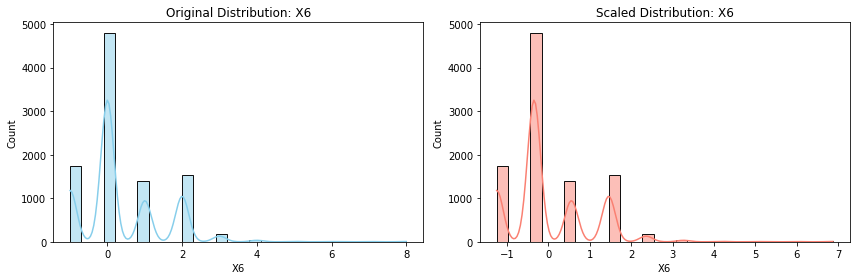

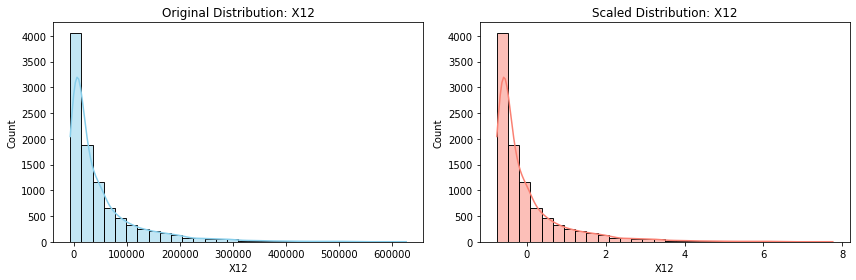

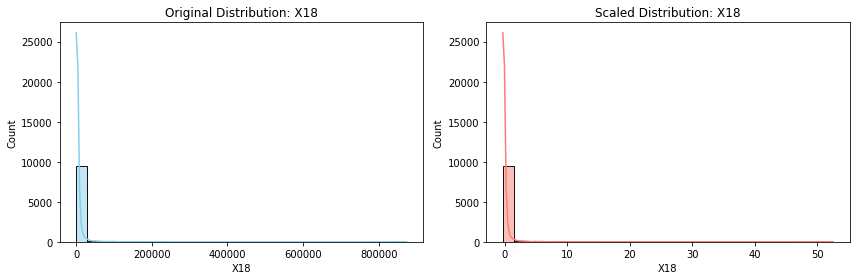

In [57]:
selected_features = ["X1", "X5", "X6", "X12", "X18"]

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

for feature in selected_features:
    plt.figure(figsize=(12, 4))

    # Original distribution
    plt.subplot(1, 2, 1)
    sns.histplot(X_train[feature], kde=True, bins=30, color='skyblue')
    plt.title(f"Original Distribution: {feature}")

    # Scaled distribution
    plt.subplot(1, 2, 2)
    sns.histplot(X_train_scaled_df[feature], kde=True, bins=30, color='salmon')
    plt.title(f"Scaled Distribution: {feature}")

    plt.tight_layout()
    plt.show()

In [58]:
print("Before Scaling:")
print(X_train[selected_features].describe())

Before Scaling:
                  X1           X5           X6            X12            X18
count    9750.000000  9750.000000  9750.000000    9750.000000    9750.000000
mean   154596.685128    35.551385     0.384821   50078.142872    5024.239385
std    127038.656035     9.427644     1.108262   74301.654921   16523.722347
min     10000.000000    21.000000    -1.000000   -6676.000000       0.000000
25%     50000.000000    28.000000     0.000000    3381.250000     390.000000
50%    120000.000000    34.000000     0.000000   20830.000000    2000.000000
75%    220000.000000    42.000000     1.000000   62267.750000    4710.750000
max    760000.000000    75.000000     8.000000  626648.000000  873552.000000


In [59]:
print("\nAfter Scaling:")
print(X_train_scaled_df[selected_features].agg(['mean', 'std']))


After Scaling:
                X1            X5            X6           X12           X18
mean -5.028456e-17  2.368476e-16  5.830094e-18 -2.040533e-17 -4.736952e-18
std   1.000051e+00  1.000051e+00  1.000051e+00  1.000051e+00  1.000051e+00


**Explanation:**

We separated the datasets of train and test from features and label to fit a Decision Tree model. Use the last column as a label and all the other columns are features for fitting the model.

### Step 5: Modelling

**Solution:**

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (Depth 2 Decision Tree): {test_accuracy:.4f}")

Test Accuracy (Depth 2 Decision Tree): 0.9040


**Explanation:**

Fitted model on the training set, give %90 accuracy on the test set.

### Step 6: Visualization

**Solution:**

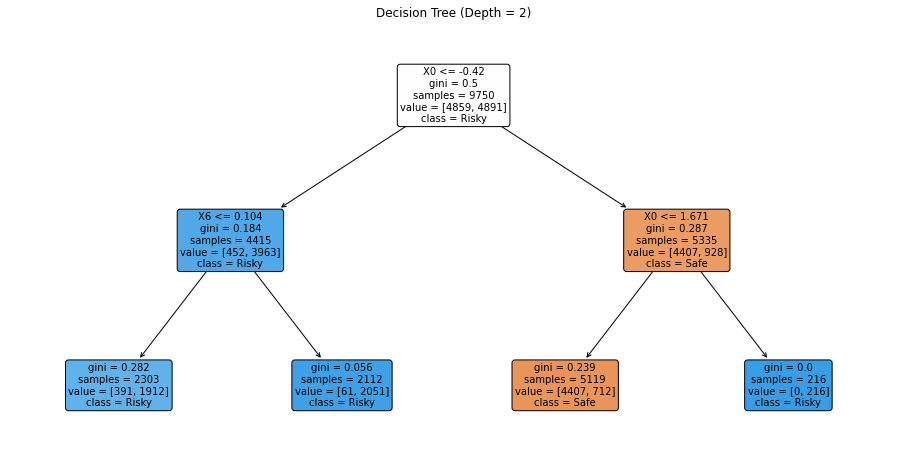

In [61]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 8))


plot_tree(
    tree_clf,
    feature_names=X_train.columns,
    class_names=["Safe", "Risky"],
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title("Decision Tree (Depth = 2)")
plt.show()

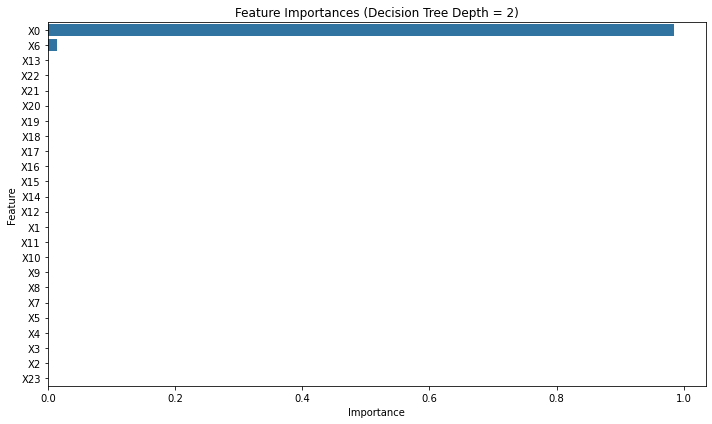

In [62]:
importances = tree_clf.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importances (Decision Tree Depth = 2)")
plt.tight_layout()
plt.show()

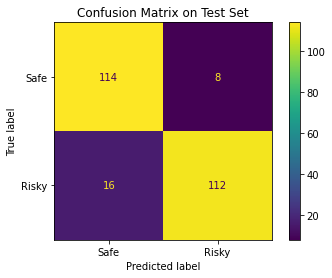

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(tree_clf, X_test_scaled, y_test, display_labels=["Safe", "Risky"])
plt.title("Confusion Matrix on Test Set")
plt.show()

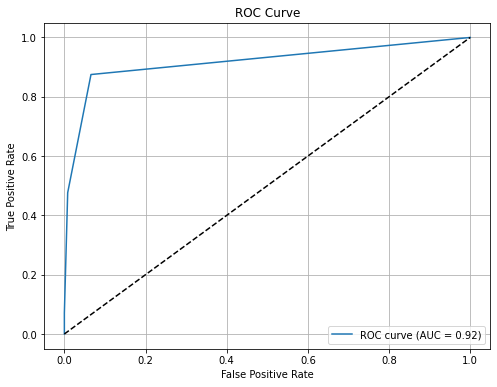

In [64]:
from sklearn.metrics import roc_curve, auc

y_prob = tree_clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Explanation:**

We can see the created decision tree with which conditions are splitted in the each step. We can also see the feature importance but in depth 2 decision tree, we only have 2 features so visualization only compare the importance of two features which are X0 and X6. Furhter visualizations show the performance of the fitted model on test set with confusion matric and ROC curve. 

### Step 7: Interpretation

**Solution:**

Test Accuracy: 0.9040
This indicates the proportion of loan applications correctly classified as safe or risky.

Confusion Matrix: Gives insight into how well the model handles:
* False Positives (safe predicted, but actually risky)
* False Negatives (risky predicted, but actually safe)

The shallow depth of the tree makes it simple to extract the rules that the model uses. For example:
If Repayment in September ≤ X and Amount of credit ≤ Y, then classify as safe, else risky. 
These guidelines make the model's predictions clear and help in understanding the characteristics that influence the choice.

* Shallow tree (depth = 2) is likely too simple to capture complex patterns.
* It could be very biased and miss nuances in repayment patterns.


**Explanation:**

In [ ]:
#Explanation here

### Part 2(b): An ensemble of decision trees

- One way to improve the prediciton accuracy for this task is to use an ensemble of decision trees fitted on random samples, as follows: given a training set of size $n$, sample new training sets uniformly with replacement, and fit a decision tree model on each random sample.

  Now, how would you combine the ensemble into a single classifier? There are at lease two ways:

   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   
   

- We can also fit a *Random Forest* model for our data (`sklearn.ensemble.RandomForestClassifier`).

Is there a significant difference in the prediction accuracies of the above three approaches on the loan data set? If so, explain why.


**Note:**  The Random Forest approach can easily overfit the training set. What are the important parameters in `sklearn`'s Random Forest fitting function that influence the model fit? For the risk assessment task, you **need** to fit your random forest model by using a suitable model selection procedure to tune these parameters.





## Step 1: Prepare data

**Solution:**

In [104]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

**Explanation:**

In [ ]:
# I already created the dataset for the first part, instead of creating from stracht I used the same split

## Step 2: Modelling

**Solution:**

In [105]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import random

#y_train = y_train.astype(int)
#y_test = y_test.astype(int)

n_trees = 50  # Number of trees in the ensemble
max_depth = 5  # depth limit

trees = []
n_samples = X_train_scaled.shape[0]

for _ in range(n_trees):
    # Bootstrap sampling with replacement
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    X_sample = X_train_scaled[indices]
    y_sample = y_train.iloc[indices]
    
    # Train decision tree on bootstrap sample
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_sample, y_sample)
    trees.append(tree)

In [106]:
def random_classifier_predict(trees, X):
    predictions = []
    for x in X:
        tree = random.choice(trees)
        pred = tree.predict([x])[0]
        predictions.append(pred)
    return np.array(predictions)

In [107]:
def majority_vote_predict(trees, X):
    all_preds = np.array([tree.predict(X) for tree in trees])  # shape: (n_trees, n_samples)
    all_preds = all_preds.astype(int) 

    majority_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_preds)
    return majority_preds

In [108]:
rf = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [109]:
random_preds = random_classifier_predict(trees, X_test_scaled)
majority_preds = majority_vote_predict(trees, X_test_scaled)
rf_preds = rf.predict(X_test_scaled)

In [110]:
acc_random = accuracy_score(y_test, random_preds)
acc_majority = accuracy_score(y_test, majority_preds)
acc_rf = accuracy_score(y_test, rf_preds)

In [111]:
print(f"Accuracy (Random classifier): {acc_random:.4f}")
print(f"Accuracy (Majority vote classifier): {acc_majority:.4f}")
print(f"Accuracy (Random Forest): {acc_rf:.4f}")

Accuracy (Random classifier): 0.9120
Accuracy (Majority vote classifier): 0.9120
Accuracy (Random Forest): 0.9040


**Explanation:**

- Random Classifier:
Here, one decision tree is chosen at random from the ensemble for every test sample in order to make predictions. The variability between individual trees trained on bootstrap samples is simulated by this method. Despite being straightforward, it does not take advantage of the pooled knowledge of all trees.
- Majority Vote Classifier:
This approach selects the class with the most votes by combining predictions from each tree in the ensemble. Combining multiple weak learners lowers variation and usually increases accuracy when compared to using just one tree.
- Random Forest:
This is an optimized ensemble of decision trees that leverages the votes from every tree to make predictions and adds extra unpredictability (such random feature selection at splits). In general, Random Forest models outperform individual trees or simple ensembles by minimizing overfitting.


* On the test set, the majority vote classifier and the random classifier both had an accuracy of about 91.2%.
* Using the existing default values, the Random Forest model produced a somewhat lower accuracy of roughly 90.4%.
* It appears that the ensemble's trees are rather constant in this experiment, and random selection among trees performs almost as well as majority voting, based on the unexpectedly similar performance of the random and majority vote classifiers.
* The default Random Forest's poorer performance could be the result of inadequate tuning or less-than-ideal hyperparameters, which can cause overfitting or underfitting.

Important parameters enhance Random Forest:
* n_estimators
* max_depth
* min_samples_split and min_samples_leaf
* max_features

## Step 3: Model selection (Random Forest)

**Solution:**

In [112]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
baseline_rf_acc = rf.score(X_test, y_test)
print(f"Baseline Random Forest accuracy: {baseline_rf_acc:.4f}")

Baseline Random Forest accuracy: 0.8960


In [113]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_val_pred)
print(f"Random Forest accuracy with tuned params: {accuracy:.4f}")

Random Forest accuracy with tuned params: 0.9160


**Explanation:**

We can try different parameters to achieve better performances in Ranfom Forest because all the parameter changes affected created trees so random forest classifier. We can get different performance results with different initialized trees. We can try with the grid search to finbd best approaches. 

## Step 4: Visualization

**Solution:**

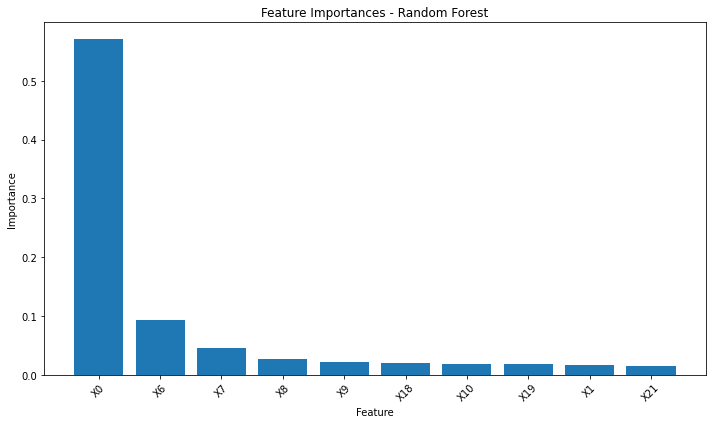

In [83]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names = [f"X{i}" for i in range(X_train.shape[1])]

plt.figure(figsize=(10,6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(10), importances[indices][:10], align='center')
plt.xticks(range(10), [feature_names[i] for i in indices][:10], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


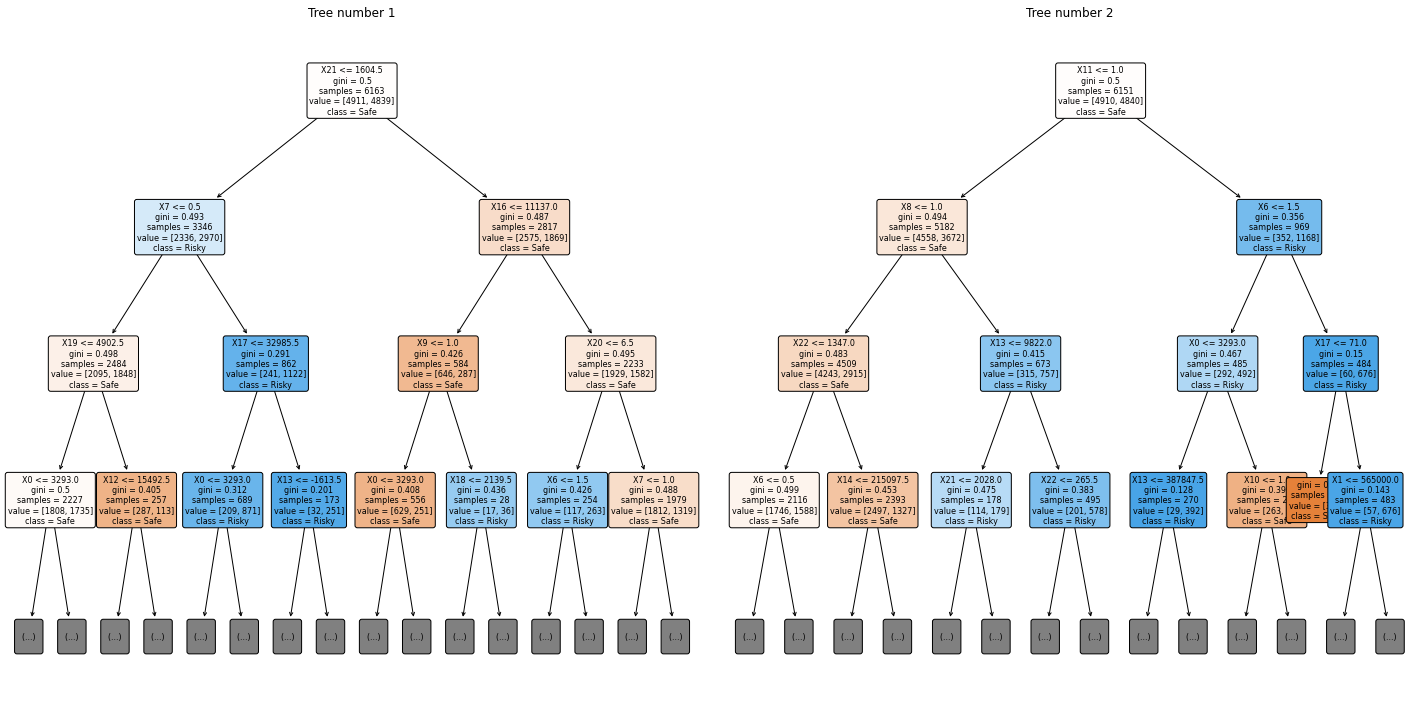

In [85]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plot_tree(
        rf.estimators_[i],  
        feature_names=[f"X{j}" for j in range(X_train.shape[1])],
        class_names=['Safe', 'Risky'],
        filled=True,
        rounded=True,
        fontsize=8,
        max_depth=3  
    )
    plt.title(f"Tree number {i+1}")

plt.tight_layout()
plt.show()

**Explanation:**

We can plotted the separated trees inside of the Random Forest too see different separated conditions on bootstrapped data with sampling. We can also visualize the features based on their importance to understand better which feature explains most of the pattern.

## Step 5: Parameter optimization (grid search)

**Solution:**

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

n_estimators_list = [50, 100, 200]
max_depth_list = [None, 5, 10]
min_samples_split_list = [2, 5, 10]
min_samples_leaf_list = [1, 2, 4]
max_features_list = ['sqrt', 'log2']

best_score = 0
best_params = {}

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                for max_features in max_features_list:
      
                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        random_state=42,
                        n_jobs=-1
                    )
                    
                    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
                    mean_score = np.mean(scores)
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features
                        }
                    
                    print(f"Params: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, "
                          f"min_samples_leaf={min_samples_leaf}, max_features={max_features} --> Accuracy: {mean_score:.4f}")

print("\nBest params:", best_params)
print(f"Best cross-validation accuracy: {best_score:.4f}")

Params: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt --> Accuracy: 0.8829
Params: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=log2 --> Accuracy: 0.8829
Params: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=sqrt --> Accuracy: 0.8842
Params: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=log2 --> Accuracy: 0.8842
Params: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4, max_features=sqrt --> Accuracy: 0.8826
Params: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4, max_features=log2 --> Accuracy: 0.8826
Params: n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1, max_features=sqrt --> Accuracy: 0.8826
Params: n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1, max_features=log2 --> Accuracy: 0.8826
Params: n_estimators=50, max_dep

In [120]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

dt_preds = dt.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_preds)
print(f"Decision Tree Test Accuracy: {dt_accuracy:.4f}")

Decision Tree Test Accuracy: 0.8560


**Explanation:**

Using 5-fold cross-validation, conducted a grid search across several Random Forest model hyperparameters to determine the optimal combination that maximizes prediction accuracy on the training data. We adjusted the following parameters:

* Number of trees (n_estimators): 50, 100, 200
* Maximum tree depth (max_depth): values like 5 and 10 (excluding None for better control)
* Minimum samples required to split a node (min_samples_split): 2, 5, 10
* Minimum samples required at a leaf node (min_samples_leaf): 1, 2, 4Number of features to consider when looking for the best split (max_features): 'sqrt' and 'log2'

Models with unlimited depth (max_depth=None) often performed marginally worse or similarly to models with a maximum depth of 10, according to the search results, suggesting that limiting tree complexity can help avoid overfitting.

The best performing model used the following parameters:
* n_estimators = 200 (more trees help stabilize predictions)
* max_depth = 10 (controls complexity and prevents overfitting)
* min_samples_split = 5 and min_samples_leaf = 2 (help reduce overfitting by requiring splits and leaves to have more samples)
* max_features = 'sqrt'


## Step 6: Build final model

**Solution:**

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

final_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train, y_train)

y_pred = final_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Test set accuracy: 0.9120

Classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       122
         1.0       0.92      0.91      0.91       128

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250

Confusion matrix:
[[112  10]
 [ 12 116]]


**Explanation:**

With the best parameters chosen from grid search, test accuracy give %91 accuracy which is better than decision tree classifier.

We can see that with the parameter optimization, we can get higher test accuracy result with compared to the original base Random Forest classifier with %89 accuracy where 91% accuracy with the gird search. Also we can see that Random Forest perform better with compare to the Decision Tree with %85 accuracy on the test set. Also from the first part, we can see that Decision Tree with depth=2 perform better without depth parameter which has 90% accuracy but again tuning the parameters of Random Forest give better performance than that.

## Step 7: Evaluation

**Solution:**

In [128]:
final_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train, y_train)

y_pred = final_rf.predict(X_test)
y_proba = final_rf.predict_proba(X_test)[:,1]  # probability estimates for positive class

In [129]:
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.9120


In [130]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[112  10]
 [ 12 116]]


In [126]:
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       122
         1.0       0.92      0.91      0.91       128

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



In [131]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

ROC AUC Score: 0.9422


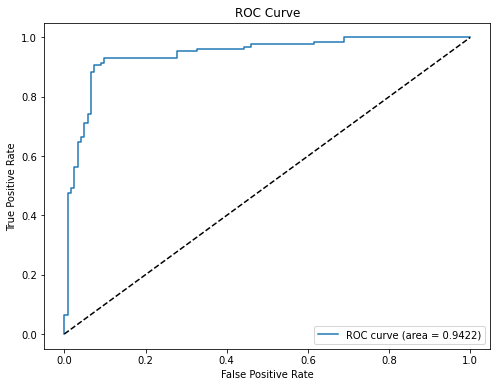

In [132]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

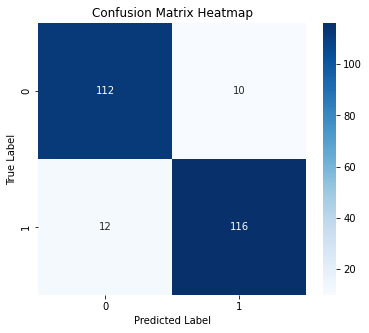

In [133]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

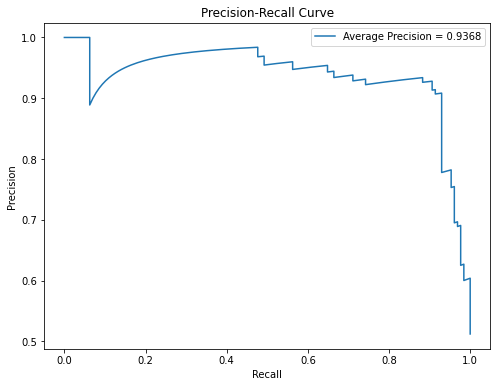

In [134]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

**Explanation:**

For evaluate Random Forest model further with the tuned parameters, we can look for accuracy, classification report, ROC/AUC Score and confusion matrix on the test set. 